<a href="https://colab.research.google.com/github/Wonhochoi123/Skin_Cancer_Detection_-Final_Project-/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 16 05:50:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:

import shutil

shutil.copy('/content/gdrive/MyDrive/Dataset2.zip','/content/Dataset2.zip')



'/content/Dataset2.zip'

In [4]:
# Navigate to the copied file and unzip it quietly
!unzip -q '/content/Dataset2.zip'

classes_train/BKL/ISIC_0063993.jpg  bad CRC 190d73bb  (should be 97b29ea1)
classes_train/BKL/ISIC_0072343.jpg  bad CRC f577bf6b  (should be 76429ba7)
classes_train/BKL/ISIC_0072421.jpg  bad CRC 2a828e7d  (should be 2240415f)
classes_train/MEL/ISIC_0032396.jpg  bad CRC 1397f0c9  (should be b0c49090)
classes_train/MEL/ISIC_0053960.jpg  bad CRC 02e8a7a4  (should be 3a50f216)
classes_train/MEL/ISIC_0057044.jpg  bad CRC cf9c2ae4  (should be 3bd4fcaa)
classes_train/MEL/ISIC_0057048.jpg  bad CRC fb2fb66c  (should be 409e0d3a)
classes_train/MEL/ISIC_0061049.jpg  bad CRC 08f30e5c  (should be ed58c0ff)
classes_train/NV/ISIC_0025028.jpg  bad CRC a73ceb4b  (should be 3bcc4e54)
classes_train/NV/ISIC_0025042.jpg  bad CRC b18fb418  (should be 0308d4c0)
classes_train/NV/ISIC_0025406.jpg  bad CRC e2c13866  (should be 2fefaa14)
classes_train/NV/ISIC_0027530.jpg  bad CRC 83d26a31  (should be 659b5124)
classes_train/NV/ISIC_0027547.jpg  bad CRC 297c247c  (should be 6589dc32)
classes_train/NV/ISIC_0030049.

In [5]:
#Let's start with importing most of the modules to use to begin with
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, img_to_array
import keras.utils # convert to one-hot-encoding

import tensorflow as tf
from sklearn.utils import class_weight

import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt 

In [6]:
#let's set up how we would train the model
S=224

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    horizontal_flip = True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

training_set = train_datagen.flow_from_directory('/content/classes_train',
                                                 target_size = (S,S),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')


testing_set = test_datagen.flow_from_directory('/content/classes_test',
                                               target_size = (S,S),
                                               batch_size = 128,
                                               shuffle=False,
                                               class_mode = 'categorical')

Found 20262 images belonging to 8 classes.
Found 5069 images belonging to 8 classes.


In [7]:

#This is how the classes coded
training_set.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

In [8]:
# In order to make class_weight dictionary, I'm making a dict of class:count
import glob
labels_dict={}
for i in training_set.class_indices:

  labels_dict[training_set.class_indices[str(i)]]=len(glob.glob("/content/classes_train/"+i+"/*.jpg"))


In [9]:
# It's a very imbalanced data! We better weigh differenty by class
labels_dict

{0: 693, 1: 2658, 2: 2099, 3: 191, 4: 3617, 5: 10300, 6: 502, 7: 202}

In [10]:
import numpy as np
import math
# formula for class_weight

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    
    for key in keys:
        score = (mu*total/(2*float(labels_dict[key])))
        class_weight[key] = score 
    
    return class_weight

In [11]:
class_weight=create_class_weight(labels_dict)

In [12]:
class_weight

{0: 2.1928571428571426,
 1: 0.571726862302483,
 2: 0.7239876131491185,
 3: 7.956282722513088,
 4: 0.42014100082941663,
 5: 0.1475388349514563,
 6: 3.0271912350597607,
 7: 7.5230198019801975}

In [13]:

# weighing more for dangerouse leigion. so we boost true positives for those 
# dangerous:ak,bcc,mel,scc
def weight_change(mul):
  for i in [0,1,4,6]:
    class_weight[i]=class_weight[i]*mul
  # for k in [2,3,5,7]:
  #   class_weight[k]=class_weight[k]/mul

In [14]:
weight_change(1.5)
class_weight

{0: 3.2892857142857137,
 1: 0.8575902934537245,
 2: 0.7239876131491185,
 3: 7.956282722513088,
 4: 0.630211501244125,
 5: 0.1475388349514563,
 6: 4.540786852589641,
 7: 7.5230198019801975}

In [ ]:
#setting the base model
resent_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=[S,S,3])
for layer in resent_model.layers:
    layer.trainable = False

94674944/94668760 [==============================] - 1s 0us/step


In [ ]:
# # initialising sequential model and adding layers to it
# classifier = Sequential()
# classifier.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
# classifier.add(MaxPool2D(pool_size=2, strides=2))
# classifier.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
# classifier.add(MaxPool2D(pool_size=2, strides=2))
# classifier.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
# classifier.add(MaxPool2D(pool_size=2, strides=2))
# classifier.add(GlobalAveragePooling2D())
# classifier.add(Dense(8, activation='softmax'))

# # finally compile and train the cnn
# classifier.compile(
#     optimizer=keras.optimizers.Adam(lr=0.0001, decay=1e-6), #regularization to prevent overfitting
#     loss='categorical_crossentropy',
#     metrics = ['accuracy']
# )
# print(classifier.summary())
# keras.utils.plot_model(classifier)


In [46]:
# A little bit of customization
from keras import regularizers
l2 = regularizers.l2(0.10)

x = Conv2D(128, (3, 3), activation='relu')(resent_model.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(64,activation='relu', kernel_regularizer=l2)(x)
x = Dense(8,activation='softmax')(x)

model = Model(inputs=resent_model.input, outputs=x)


In [ ]:
model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
____________________________________________________________________________________________

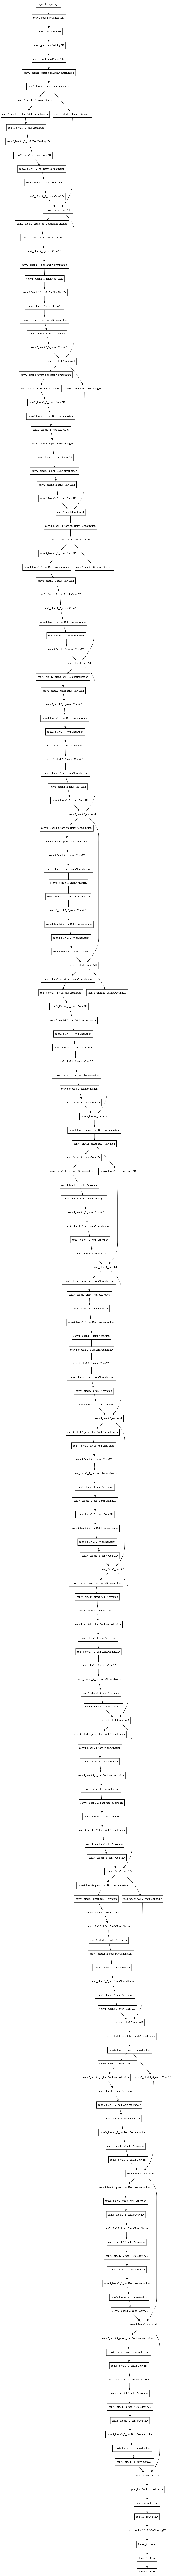

In [47]:
# opt = keras.optimizers.Adam(learning_rate=3e-4*30) ended up not using it
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, decay=1e-6), #regularization to prevent overfitting
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
print(model.summary())
keras.utils.plot_model(model)

In [16]:
from tensorflow.keras.models import load_model

model=keras.models.load_model('/content/model_f.h5')

In [17]:
from keras.callbacks import ReduceLROnPlateau

In [ ]:
#And now we are fitting the model.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
hist = model.fit(training_set,
                validation_data = testing_set,
                epochs = 200,class_weight=class_weight,callbacks=[reduce_lr])

Epoch 1/200
159/159 [==============================] - 536s 3s/step - loss: 0.5126 - accuracy: 0.6450 - val_loss: 1.2296 - val_accuracy: 0.5804
Epoch 2/200
159/159 [==============================] - 511s 3s/step - loss: 0.5063 - accuracy: 0.6449 - val_loss: 1.0644 - val_accuracy: 0.6179
Epoch 3/200
159/159 [==============================] - 488s 3s/step - loss: 0.4821 - accuracy: 0.6574 - val_loss: 1.0739 - val_accuracy: 0.6246
Epoch 4/200
159/159 [==============================] - 487s 3s/step - loss: 0.4866 - accuracy: 0.6576 - val_loss: 1.0764 - val_accuracy: 0.6135
Epoch 5/200
159/159 [==============================] - 489s 3s/step - loss: 0.4650 - accuracy: 0.6618 - val_loss: 1.0623 - val_accuracy: 0.6315
Epoch 6/200
159/159 [==============================] - 490s 3s/step - loss: 0.4663 - accuracy: 0.6574 - val_loss: 1.0715 - val_accuracy: 0.6206
Epoch 7/200
159/159 [==============================] - 489s 3s/step - loss: 0.4742 - accuracy: 0.6506 - val_loss: 1.0721 - val_accuracy:

In [ ]:
from tensorflow.keras.models import load_model

from google.colab import files

model.save('model_f_4.h5')

files.download('model_f_4.h5') 

In [31]:
#And now we are fitting the model.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
hist = model.fit(training_set,
                validation_data = testing_set,
                epochs = 80,class_weight=class_weight,callbacks=[reduce_lr])

Epoch 1/80
159/159 [==============================] - 464s 3s/step - loss: 0.9465 - accuracy: 0.5988 - val_loss: 1.3657 - val_accuracy: 0.5396
Epoch 2/80
159/159 [==============================] - 447s 3s/step - loss: 0.9584 - accuracy: 0.5965 - val_loss: 1.3420 - val_accuracy: 0.5543
Epoch 3/80
159/159 [==============================] - 442s 3s/step - loss: 0.9270 - accuracy: 0.6069 - val_loss: 1.3499 - val_accuracy: 0.5447
Epoch 4/80
159/159 [==============================] - 436s 3s/step - loss: 0.9364 - accuracy: 0.6011 - val_loss: 1.3292 - val_accuracy: 0.5532
Epoch 5/80
159/159 [==============================] - 437s 3s/step - loss: 0.9283 - accuracy: 0.6028 - val_loss: 1.2554 - val_accuracy: 0.5833
Epoch 6/80
159/159 [==============================] - 438s 3s/step - loss: 0.8996 - accuracy: 0.6142 - val_loss: 1.4002 - val_accuracy: 0.5342
Epoch 7/80
159/159 [==============================] - 436s 3s/step - loss: 0.9039 - accuracy: 0.6023 - val_loss: 1.2754 - val_accuracy: 0.5699

KeyboardInterrupt: ignored

In [34]:

from tensorflow.keras.models import load_model

from google.colab import files

model.save('model_15.h5')

files.download('model_15.h5') 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
from tensorflow.keras.models import load_model

model=keras.models.load_model('/content/model_15.h5')

In [84]:
# opt = keras.optimizers.Adam(learning_rate=3e-4*30) ended up not using it
model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, decay=1e-6), #regularization to prevent overfitting
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)
# print(model.summary())
# keras.utils.plot_model(model)


In [85]:
#And now we are fitting the model.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
hist = model.fit(training_set,
                validation_data = testing_set,
                epochs = 40,class_weight=class_weight,callbacks=[reduce_lr])

Epoch 1/40
 16/159 [==>...........................] - ETA: 5:26 - loss: 1.8378 - accuracy: 0.4610

KeyboardInterrupt: ignored

In [ ]:
-
from tensorflow.keras.models import load_model

from google.colab import files

model.save('model_16.h5')

files.download('model_16.h5') 


In [102]:
from sklearn.metrics import accuracy_score
predict=model.predict(testing_set)
y_pred = np.argmax(predict, axis=1)
accuracy_score(testing_set.labels,y_pred)


0.6427303215624384

In [35]:
from sklearn.metrics import confusion_matrix

y_true=testing_set.labels
cm=confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7])



In [36]:
def true_positve_rate(cm):
  for i in testing_set.class_indices.keys():
    ID=testing_set.class_indices[i]
    print('true_positve_rate of '+i,cm[ID][ID]/cm[ID].sum())




In [37]:
true_positve_rate(cm)

true_positve_rate of AK 0.4482758620689655
true_positve_rate of BCC 0.6766917293233082
true_positve_rate of BKL 0.44952380952380955
true_positve_rate of DF 0.3541666666666667
true_positve_rate of MEL 0.7712707182320442
true_positve_rate of NV 0.5728155339805825
true_positve_rate of SCC 0.47619047619047616
true_positve_rate of VASC 0.5294117647058824


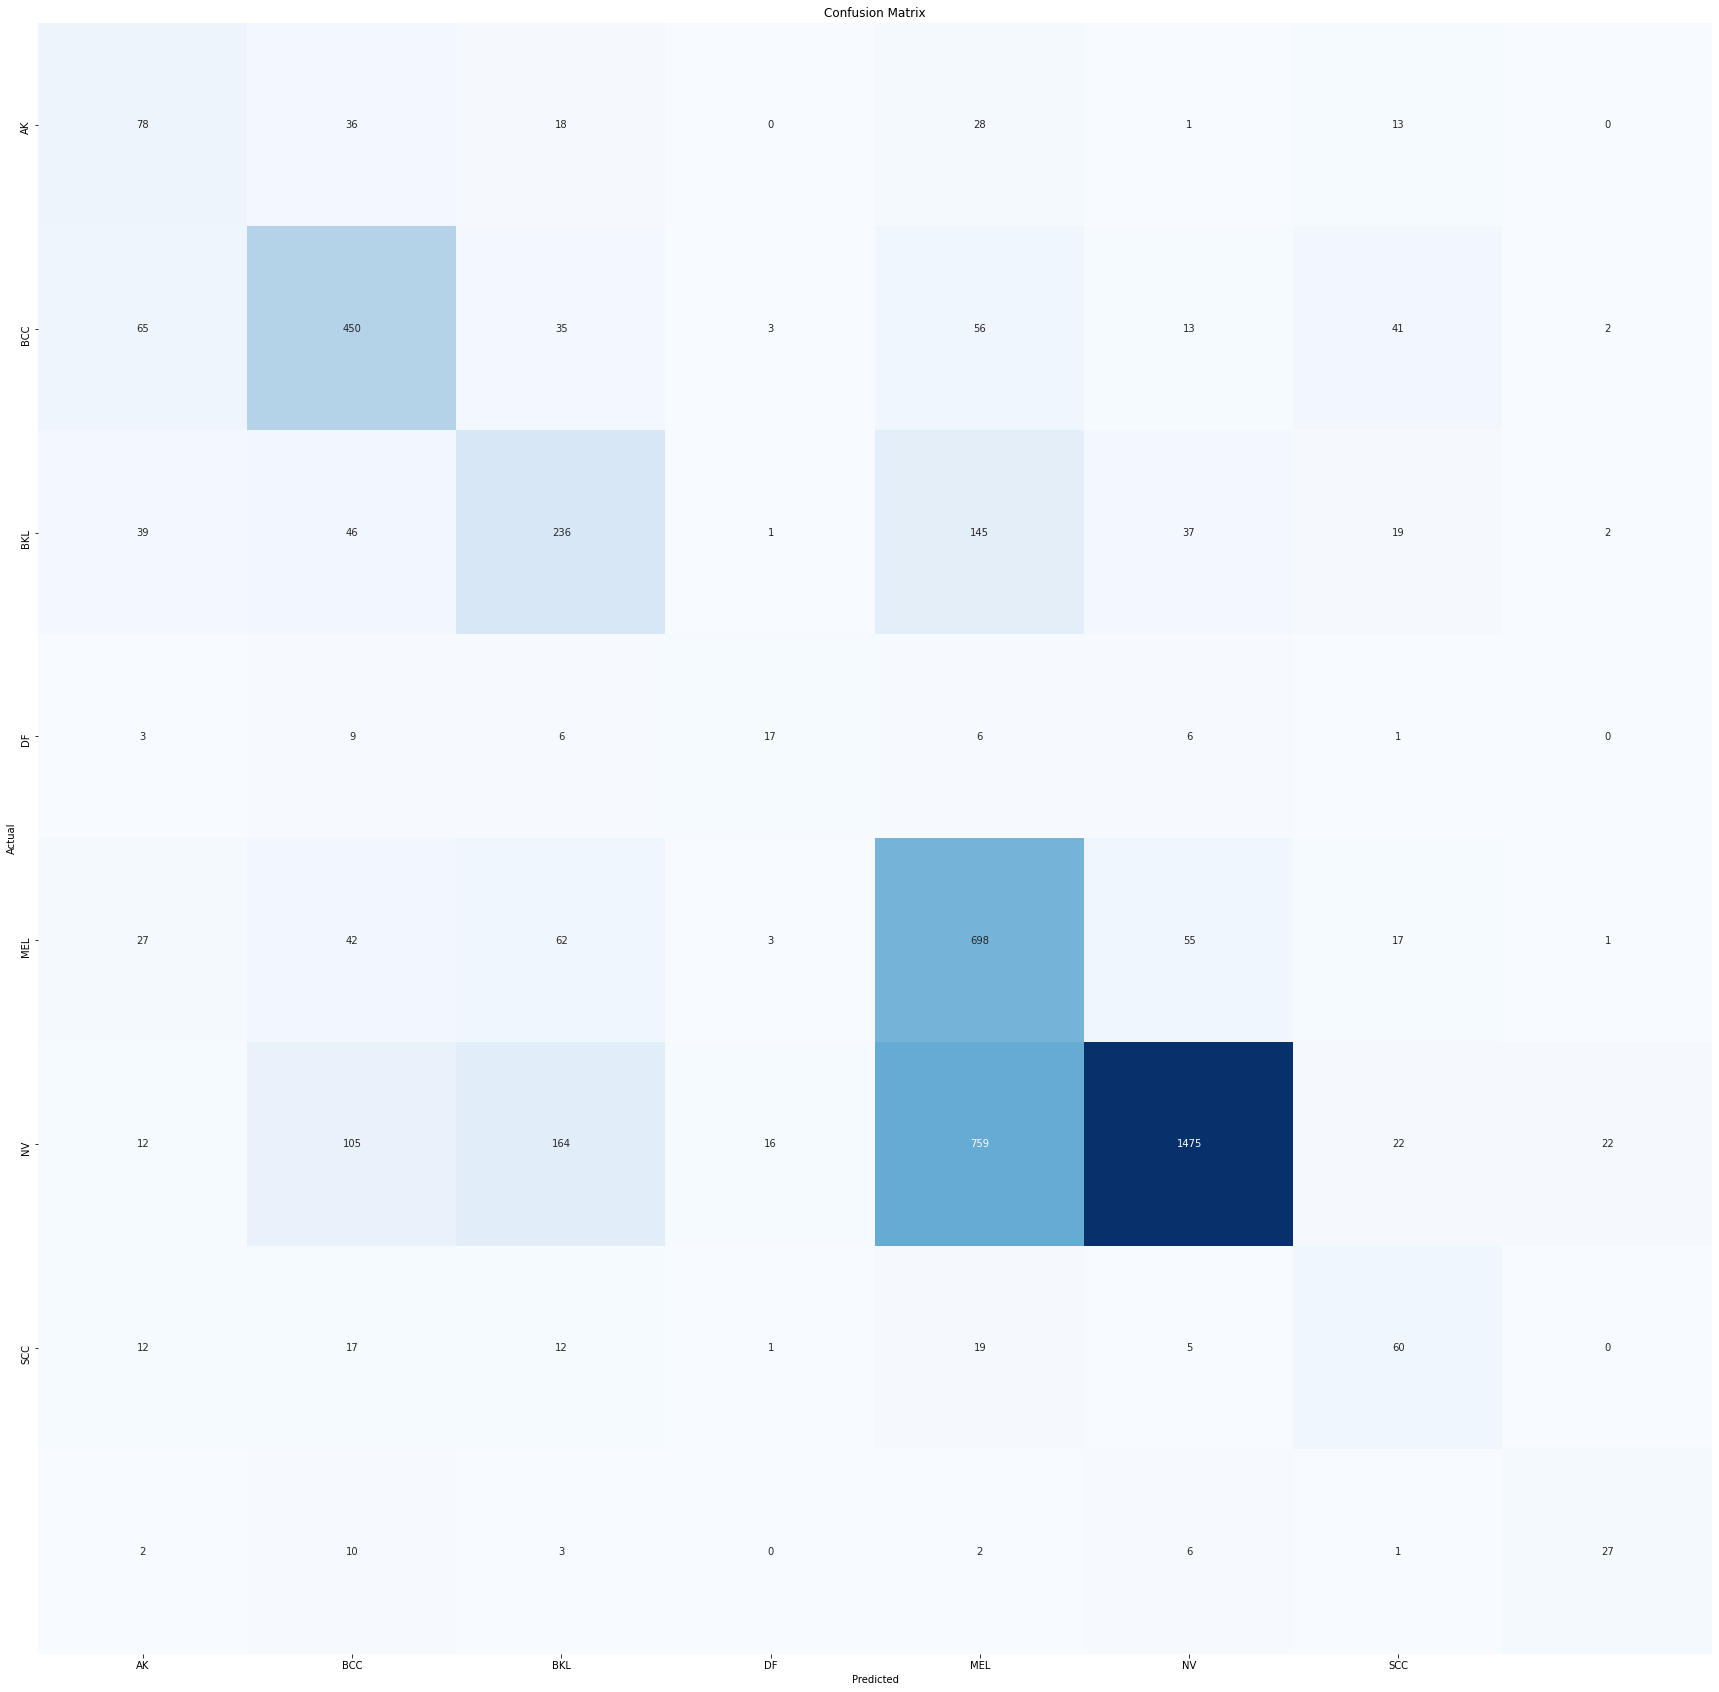

In [38]:
import seaborn as sns
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')

plt.xticks(np.arange(7) + 0.5, testing_set.class_indices.keys())
plt.xlabel("Predicted")

plt.yticks(np.arange(7) + 0.5, testing_set.class_indices.keys())
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

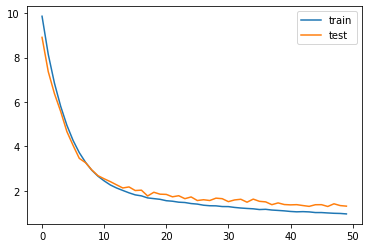

In [ ]:
from matplotlib import pyplot as plt
# plot history
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

In [41]:
from matplotlib import pyplot as plt
# plot history
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
shutil.copy('model_14.h5','/content/drive/MyDrive/model_14.h5')

FileNotFoundError: ignored

In [42]:
model_acc = model.evaluate(testing_set)

40/40 [==============================] - 74s 2s/step - loss: 1.1672 - accuracy: 0.5999


In [43]:
model_acc

[1.1672470569610596, 0.5999211072921753]

In [44]:
plot_confusion_matrix(model, testing_set, testing_set.classes)  
plt.show()  

NameError: ignored

In [ ]:
model=new_model

In [ ]:
#And now we are fitting the model.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
hist = model.fit(training_set,
                validation_data = testing_set,
                epochs = 50,class_weight=class_weight,callbacks=[reduce_lr])

In [ ]:
from tensorflow.keras.models import load_model

from google.colab import files

model.save('model_15.h5')

files.download('model_15.h5') 

In [ ]:
try:
  from tensorflow.keras.models import load_model
except:
  pass
try:
  from google.colab import files
except:
  pass
try:
  model.save('model_5/12.h5')
except:
  pass
try:
  files.download('model_5/12.h5') 
except:
  pass

In [ ]:
try:

  hist.model.save('model_5/12_hist.h5')
except:
  pass

try:
  files.download('model_5/12_hist.h5') 
except:
:
  pass

IndentationError: ignored

In [ ]:
#Reproducible Results
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
#Basics
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#CNN Model
import keras
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 2.9MB/s 


In [ ]:
#Reproducible Results
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
#Basics
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
#CNN Model
import keras
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D ,GlobalAveragePooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#Optimisation
! pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Integer,Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

     |████████████████████████████████| 102kB 6.3MB/s 


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_126 (MaxPoolin (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_128 (MaxPoolin (None, 6, 6, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)              

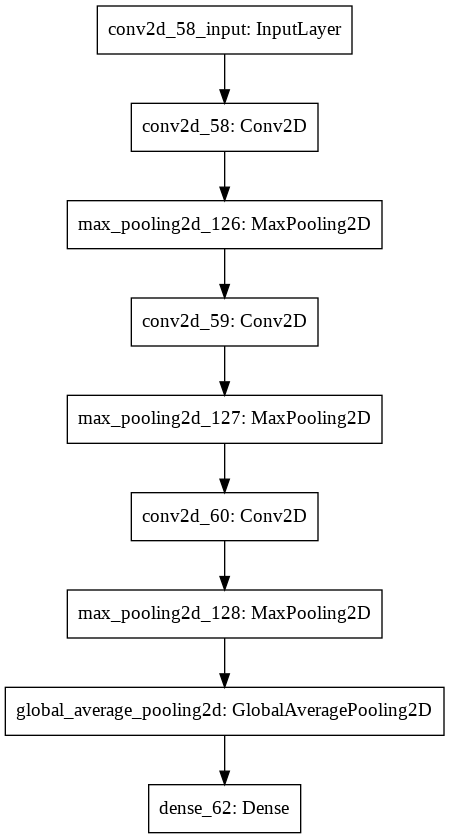

In [ ]:
# initialising sequential model and adding layers to it
classifier = Sequential()
classifier.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
classifier.add(MaxPool2D(pool_size=2, strides=2))
classifier.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
classifier.add(MaxPool2D(pool_size=2, strides=2))
classifier.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
classifier.add(MaxPool2D(pool_size=2, strides=2))
classifier.add(GlobalAveragePooling2D())
classifier.add(Dense(8, activation='softmax'))

# finally compile and train the cnn
classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

print(classifier.summary())
keras.utils.plot_model(classifier)

In [ ]:
history = classifier.fit_generator(training_set,
                         steps_per_epoch = 50,
                         epochs = 50,
                         validation_data = testing_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  def _make_callback_model(self, grouped_model):


Epoch 1/50
50/50 [==============================] - 206s 4s/step - loss: 1.4310 - accuracy: 0.5030 - val_loss: 1.4128 - val_accuracy: 0.5139
Epoch 2/50
46/50 [==========================>...] - ETA: 10s - loss: 1.4186 - accuracy: 0.5046

KeyboardInterrupt: ignored